Unsupervised segmentation from the paper:
- Unsuppervised Learning of Image Segmentation based on differentiable Feature clustering (https://arxiv.org/abs/2007.09990,
https://github.com/kanezaki/pytorch-unsupervised-segmentation-tip)

the idea is to use a convolutional neural network to transform an input image (h,w,3)
into a higher dimension image (h,w,nChannel).
Each pixel is associated with a nChannel vector.
Pixels clustering happens with these 3 rules:
- similar features vectors should be assigned the same class label
- spatially continuous vectors should be assigned the same class label
- start initially with high number of classes (nChannel)

For the features similarity, we use the crossentropy loss function between the output of the network and
the pseudo label. The pseudo label are defined by taking the argmax of the output.
For the spatial continuity, we use the L1 norm between adjacent vectors. (both in the horizontal and vertical direction). Then by gradient descent and backpropagation, the weights of the filters of the convolution layers
are adapting to minimize theses losses and to try to satisfy the above (incompatible) criterias.

In [21]:
import torch
import torch.nn as nn


from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
import cv2
import sys
import numpy as np
import torch.nn.init
import random
import copy
from torchsummary import summary
from collections import Counter
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import datetime
import tqdm
from PIL import Image

In [2]:
path_curent = Path.cwd()
path_data = path_curent.parent
path_data
use_cuda = torch.cuda.is_available()

In [11]:
path_images_ref = path_data/'datasets/ref'
path_images_test = path_data/'datasets/test'

In [13]:
list_images_ref = list(path_images_ref.iterdir())
list_image_test = list(path_images_test.iterdir())
print(f'len:images_ref:{len(list_images_ref)},images_test:{len(list_image_test)}')

len:images_ref:18,images_test:10


In [232]:
params = {"scribble":False,
          "batch_size":6,
          "nChannel": 10,
          "maxIter": 1, 
          "minLabels": 3, 
          "lr": 0.1,
          "nConv":2,
          "visualize":1,
          "input": (path_data/'datasets/').as_posix(),
          "stepsize_sim":1,
          "stepsize_con":1,
          "stepsize_scr":0.5}

In [233]:
# CNN model
class MyNet(nn.Module):
    def __init__(self, input_dim):
        super(MyNet, self).__init__()
        self.conv1 = nn.Conv2d(input_dim, params['nChannel'], kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(params['nChannel'])
        self.conv2 = nn.ModuleList()
        self.bn2 = nn.ModuleList()
        for i in range(params['nConv'] - 1):
            self.conv2.append(nn.Conv2d(params['nChannel'], params['nChannel'], kernel_size=3, stride=1, padding=1))
            self.bn2.append(nn.BatchNorm2d(params['nChannel']))
        self.conv3 = nn.Conv2d(params['nChannel'], params['nChannel'], kernel_size=1, stride=1, padding=0)
        self.bn3 = nn.BatchNorm2d(params['nChannel'])

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.bn1(x)
        for i in range(params['nConv'] - 1):
            x = self.conv2[i](x)
            x = F.relu(x)
            x = self.bn2[i](x)
        x = self.conv3(x)
        x = self.bn3(x)
        return x

In [234]:
img_list = sorted(glob.glob(params['input'] + '/ref/*'))
im = cv2.imread(img_list[0])

# train
model = MyNet(im.shape[2])
if use_cuda:
    model.cuda()
model.train()

# similarity loss definition
loss_fn = torch.nn.CrossEntropyLoss()

# continuity loss definition
loss_hpy = torch.nn.L1Loss(reduction='mean')
loss_hpz = torch.nn.L1Loss(reduction='mean')

optimizer = optim.SGD(model.parameters(), lr=params['lr'], momentum=0.9)
label_colours = np.random.randint(255, size=(100, 3))
size = (128,128)

In [235]:
def train():
    for batch_idx in range(params['maxIter']):

        print('Training started. ' + str(datetime.datetime.now()) + '   ' +
              str(batch_idx + 1) + ' / ' + str(params['maxIter']))
        for im_file in range(int(len(img_list) / params['batch_size'])):                     # 6 = 18 / 3,          bs = 6
           
            for loop in tqdm.tqdm(range(params['batch_size'])):

                im = []
                for batch_count in range(params['batch_size']):
                    # load image
                    resized_im = cv2.imread(img_list[params['batch_size'] * im_file + batch_count])
                    resized_im = cv2.resize(resized_im, dsize=size)
                    resized_im = resized_im.transpose((2, 0, 1)).astype('float32') / 255.
                    im.append(resized_im)
    
                data = torch.from_numpy(np.array(im))
               
                if use_cuda:
                    data = data.cuda()
                data = Variable(data)

                HPy_target = torch.zeros(resized_im.shape[1] - 1, resized_im.shape[2], params['nChannel'])
                HPz_target = torch.zeros(resized_im.shape[1], resized_im.shape[2] - 1, params['nChannel'])
                if use_cuda:
                    HPy_target = HPy_target.cuda()
                    HPz_target = HPz_target.cuda()

                # forwarding
                optimizer.zero_grad()
                output = model(data)[loop]
                output = output.permute(1, 2, 0).contiguous().view(-1, params['nChannel'])

                outputHP = output.reshape((resized_im.shape[1], resized_im.shape[2], params['nChannel']))

                HPy = outputHP[1:, :, :] - outputHP[0:-1, :, :]
                HPz = outputHP[:, 1:, :] - outputHP[:, 0:-1, :]
                lhpy = loss_hpy(HPy, HPy_target)
                lhpz = loss_hpz(HPz, HPz_target)

                ignore, target = torch.max(output, 1)

                im_target = target.data.cpu().numpy()
                nLabels = len(np.unique(im_target))
                loss = params['stepsize_sim'] * loss_fn(output, target) + params['stepsize_con'] * (lhpy + lhpz)
                loss.backward()
                optimizer.step()
                print(loop, '/', params['batch_size'], '|', ' label num :', nLabels, ' | loss :', loss.item())
                if nLabels <= params['minLabels']:
                    print("nLabels", nLabels, "reached minLabels", params['minLabels'], ".")
                    break
        #torch.save(model.state_dict(), os.path.join(args.input, 'b' + str(args.batch_size) + '_itr' + str(
        #    args.maxIter) + '_layer' + str(args.nConv + 1) + '.pth'))

In [ ]:
image_path = path_cur 

In [32]:
class Mydataset:
    def __init__(self, size,image_path):
        self.size = (128,128)
        self.image_path = list(image_path.iterdir())
        self.transforms = transforms.Compose([transforms.Resize(size),
                                              transforms.ToTensor()])
    def __len__(self):
        return len(self.image_path)
    
    def __getitem__(self,item):
        image = Image.open(self.image_path[item])
        tensor = self.transforms(image)
        return  tensor

In [33]:
ds = Mydataset(size=(128,128),image_path=path_images_ref)

In [35]:
tensor = ds[0]
#print(img.shape)
print(tensor.shape)
dl = torch.utils.data.DataLoader(ds, batch_size=6,shuffle=False)

torch.Size([3, 128, 128])


In [41]:
# to be continued....
def loss_item(output, target, opt=None):
    loss = params['stepsize_sim'] * loss_fn(output, target) + params['stepsize_con'] * (lhpy + lhpz)

    
    if opt is not None:
        opt.zero_grad()
        loss.backward()
        opt.step()
    return loss.item()

def loss_epoch(model,loss_func, dataloader, sanity_check=False,batch_size=6, opt=None):
    running_loss=0.0
    len_data = len(dataloader.dataset)
    for xb in dataloader:
        xb = xb.to(device)
        for item in range(batch_size):
            output = model(xb)[item]
            ignore, target = torch.max(output, dim=1)
            loss = loss_item(loss_func, output,target,opt)
            running_loss +=loss
        if sanity_check:
            break
    return loss/len_data

In [ ]:
num_epochs = 2

for epoch in range(num_epochs):
    model.train()
    loss = loss_epoch(model,loss_func,dataloader)

In [249]:
params = {"scribble":False,
          "batch_size":6,
          "nChannel": 10,
          "maxIter": 1, 
          "minLabels": 3, 
          "lr": 0.1,
          "nConv":2,
          "visualize":1,
          "input": (path_data/'datasets/').as_posix(),
          "stepsize_sim":1,
          "stepsize_con":1,
          "stepsize_scr":0.5}


In [237]:
def test():
    #label_colours = np.random.randint(255, size=(params['nChannel'], 3))
    zero, mid, high = 0, 128, 255
    label_colors = np.array([(zero, zero, zero), (zero, zero, high), (zero, high, zero),
                             (zero,zero,mid),(zero,mid,mid),
                                 (zero, high, high), (high, zero, zero), (high, zero, high),
                                 (high, high, zero), (high, high, high)])
    test_img_list = sorted(glob.glob(params['input'] + '/test/*'))
    #if not os.path.exists(os.path.join(params['input'], f'size_{size[0]}_result_bs_{params['batch_size']}_maxIter_'
    #                                               f'{params['maxIter']}_minLabels_{params['minLabels']}_con_'
    #                                               f'{params['stepsize_con']}_nchannel_{params['nChannel']}/')):
    #    os.mkdir(os.path.join(args.input, f'size_{size[0]}_result_bs_{params['batch_size']}_maxIter_'
    #                                      f'{params['maxIter']}_minLabels_{params['minLabels']}_con_'
    #                                      f'{params['stepsize_con']}_nchannel_{params['nChannel']}/'))
    print('Testing ' + str(len(test_img_list)) + ' images.')
    list_result = []
    list_inds = []
    for img_file in tqdm.tqdm(test_img_list):
        im = cv2.imread(img_file)
        data = torch.from_numpy(np.array([im.transpose((2, 0, 1)).astype('float32') / 255.]))
        if use_cuda:
            data = data.cuda()
        data = Variable(data)
        output = model(data)[0]
        output = output.permute(1, 2, 0).contiguous().view(-1, params['nChannel'])
        ignore, target = torch.max(output, 1)
        inds = target.data.cpu().numpy().reshape((im.shape[0], im.shape[1]))
        inds_rgb = np.array([label_colours[c % params['nChannel']] for c in inds])
        inds_rgb = inds_rgb.reshape(im.shape).astype(np.uint8)

        list_result.append(inds_rgb)
        list_inds.append(inds)
    return list_result, list_inds

In [238]:
 def decode_segmap(image, nc=8):

        zero, mid, high = 0, 128, 255
        label_colors = np.array([(zero, zero, zero), (zero, zero, high), (zero, high, zero),
                                 (zero, high, high), (high, zero, zero), (high, zero, high),
                                 (high, high, zero), (high, high, high)])

        r = np.zeros_like(image).astype(np.uint8)
        g = np.zeros_like(image).astype(np.uint8)
        b = np.zeros_like(image).astype(np.uint8)

        for l in range(0, nc):
            idx = image == l  # boolean matrix with False everywhere except True where img=l
            r[idx] = label_colors[l, 0]  # red channel
            g[idx] = label_colors[l, 1]
            b[idx] = label_colors[l, 2]

        rgb = np.stack([r, g, b], axis=2)

        return rgb


### 1. with maxIter=1, stepsize_con=1, lr =0.01

 50%|█████     | 3/6 [00:00<00:00, 24.31it/s]

Training started. 2020-12-14 13:55:17.904388   1 / 1
0 / 6 |  label num : 10  | loss : 1.9924379587173462
1 / 6 |  label num : 10  | loss : 1.8906853199005127
2 / 6 |  label num : 10  | loss : 1.857969045639038
3 / 6 |  label num : 10  | loss : 1.647168755531311
4 / 6 |  label num : 10  | loss : 1.474426507949829


 50%|█████     | 3/6 [00:00<00:00, 26.40it/s]

5 / 6 |  label num : 10  | loss : 1.506652593612671
0 / 6 |  label num : 8  | loss : 1.1508588790893555
1 / 6 |  label num : 9  | loss : 1.7327642440795898
2 / 6 |  label num : 9  | loss : 1.731755018234253
3 / 6 |  label num : 8  | loss : 1.2596185207366943
4 / 6 |  label num : 8  | loss : 1.0339961051940918


 50%|█████     | 3/6 [00:00<00:00, 23.52it/s]

5 / 6 |  label num : 7  | loss : 1.2060167789459229
0 / 6 |  label num : 7  | loss : 1.0034339427947998
1 / 6 |  label num : 10  | loss : 1.3142855167388916
2 / 6 |  label num : 10  | loss : 1.717857837677002
3 / 6 |  label num : 10  | loss : 1.631911039352417


 40%|████      | 4/10 [00:00<00:00, 36.34it/s]

4 / 6 |  label num : 10  | loss : 1.514139175415039
5 / 6 |  label num : 9  | loss : 1.532185435295105
Testing 10 images.


100%|██████████| 10/10 [00:00<00:00, 36.01it/s]


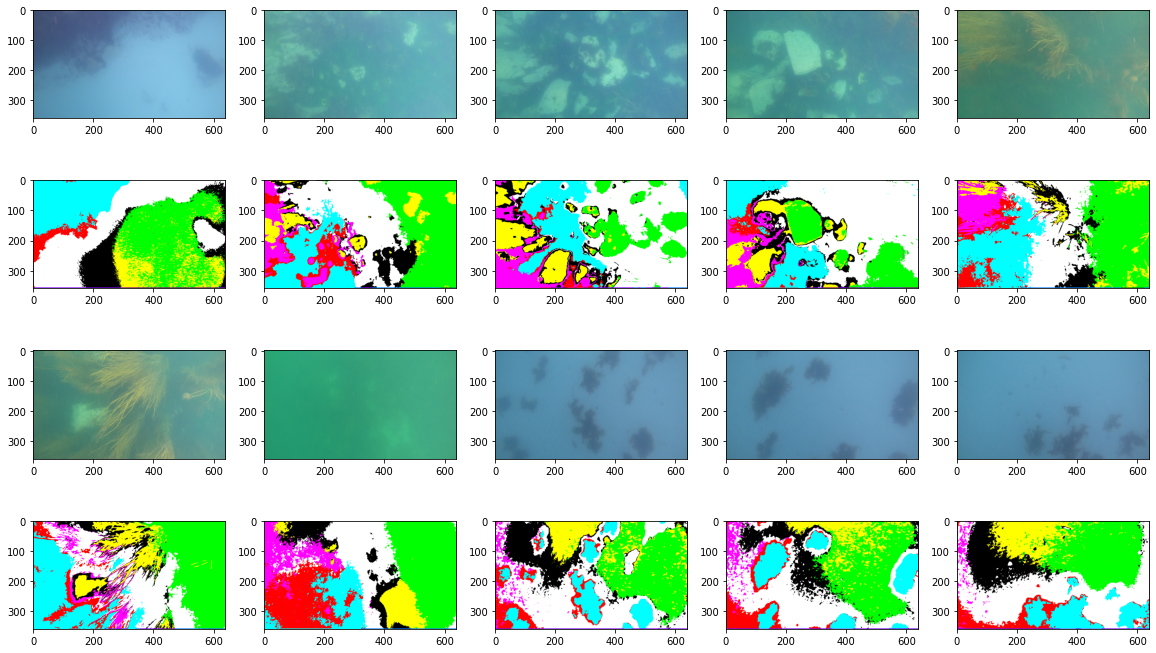

In [254]:
# resuts for maxIter = 1, stepsize_con=1
# with 1 iteration
model = MyNet(im.shape[2])
if use_cuda:
    model.cuda()
model.train()

# similarity loss definition
loss_fn = torch.nn.CrossEntropyLoss()

# continuity loss definition
loss_hpy = torch.nn.L1Loss(reduction='mean')
loss_hpz = torch.nn.L1Loss(reduction='mean')

optimizer = optim.SGD(model.parameters(), lr=params['lr'], momentum=0.9)
label_colours = np.random.randint(255, size=(100, 3))
size = (128,128)

params = {"scribble":False,
          "batch_size":6,
          "nChannel": 10,
          "maxIter": 1, 
          "minLabels": 3, 
          "lr": 0.01,
          "nConv":2,
          "visualize":1,
          "input": (path_data/'datasets/').as_posix(),
          "stepsize_sim":1,
          "stepsize_con":1,
          "stepsize_scr":0.5}


# train 
train()
# inference on test folder
list_result, list_inds = test()


fig, axs = plt.subplots(nrows=4, ncols = 5, figsize=(20,12))
ncols = 5
for col in range(ncols):
    image = mpimg.imread(img_list_test[col])
    axs[0, col].imshow(image)
#for col in range(ncols):
#    axs[1, col].imshow(list_result[col])   
for col in range(ncols):
    axs[1,col].imshow(decode_segmap(list_inds[col]))    
for col in range(ncols):
    image = mpimg.imread(img_list_test[ncols+col])
    axs[2, col].imshow(image)
#for col in range(ncols):
#    axs[4, col].imshow(list_result[ncols+col])
for col in range(ncols):
    axs[3,col].imshow(decode_segmap(list_inds[ncols+col]))

### 2. with maxIter=2, stepsize_con=1, lr =0.01

 50%|█████     | 3/6 [00:00<00:00, 24.41it/s]

Training started. 2020-12-14 13:55:49.694475   1 / 2
0 / 6 |  label num : 10  | loss : 2.0807600021362305
1 / 6 |  label num : 10  | loss : 1.7577543258666992
2 / 6 |  label num : 10  | loss : 1.7537996768951416
3 / 6 |  label num : 10  | loss : 1.6343579292297363


 50%|█████     | 3/6 [00:00<00:00, 25.26it/s]

4 / 6 |  label num : 10  | loss : 1.5634914636611938
5 / 6 |  label num : 9  | loss : 1.455260157585144
0 / 6 |  label num : 9  | loss : 1.4895119667053223
1 / 6 |  label num : 7  | loss : 1.366328239440918
2 / 6 |  label num : 7  | loss : 1.5023343563079834


 50%|█████     | 3/6 [00:00<00:00, 25.47it/s]

3 / 6 |  label num : 10  | loss : 1.5574554204940796
4 / 6 |  label num : 9  | loss : 1.2543505430221558
5 / 6 |  label num : 7  | loss : 1.386157512664795
0 / 6 |  label num : 8  | loss : 1.2000210285186768
1 / 6 |  label num : 9  | loss : 1.5259352922439575
2 / 6 |  label num : 10  | loss : 1.4890140295028687


 50%|█████     | 3/6 [00:00<00:00, 25.74it/s]

3 / 6 |  label num : 9  | loss : 1.4119949340820312
4 / 6 |  label num : 8  | loss : 1.4116861820220947
5 / 6 |  label num : 5  | loss : 1.4345800876617432
Training started. 2020-12-14 13:55:50.418925   2 / 2
0 / 6 |  label num : 8  | loss : 1.2929797172546387
1 / 6 |  label num : 7  | loss : 1.3204702138900757
2 / 6 |  label num : 7  | loss : 1.3054686784744263


  0%|          | 0/6 [00:00<?, ?it/s]

3 / 6 |  label num : 7  | loss : 1.3058058023452759
4 / 6 |  label num : 8  | loss : 1.2390236854553223
5 / 6 |  label num : 7  | loss : 1.153648853302002
0 / 6 |  label num : 5  | loss : 0.87806236743927
1 / 6 |  label num : 4  | loss : 1.0452533960342407


  0%|          | 0/6 [00:00<?, ?it/s]

2 / 6 |  label num : 5  | loss : 1.1459696292877197
3 / 6 |  label num : 6  | loss : 1.1920300722122192
4 / 6 |  label num : 7  | loss : 0.9477022886276245
5 / 6 |  label num : 6  | loss : 1.0143864154815674
0 / 6 |  label num : 5  | loss : 0.8229781985282898


  0%|          | 0/10 [00:00<?, ?it/s]

1 / 6 |  label num : 7  | loss : 1.3413615226745605
2 / 6 |  label num : 7  | loss : 1.148606777191162
3 / 6 |  label num : 4  | loss : 1.0971184968948364
4 / 6 |  label num : 6  | loss : 1.1187771558761597
5 / 6 |  label num : 4  | loss : 1.126946210861206
Testing 10 images.


100%|██████████| 10/10 [00:00<00:00, 37.98it/s]


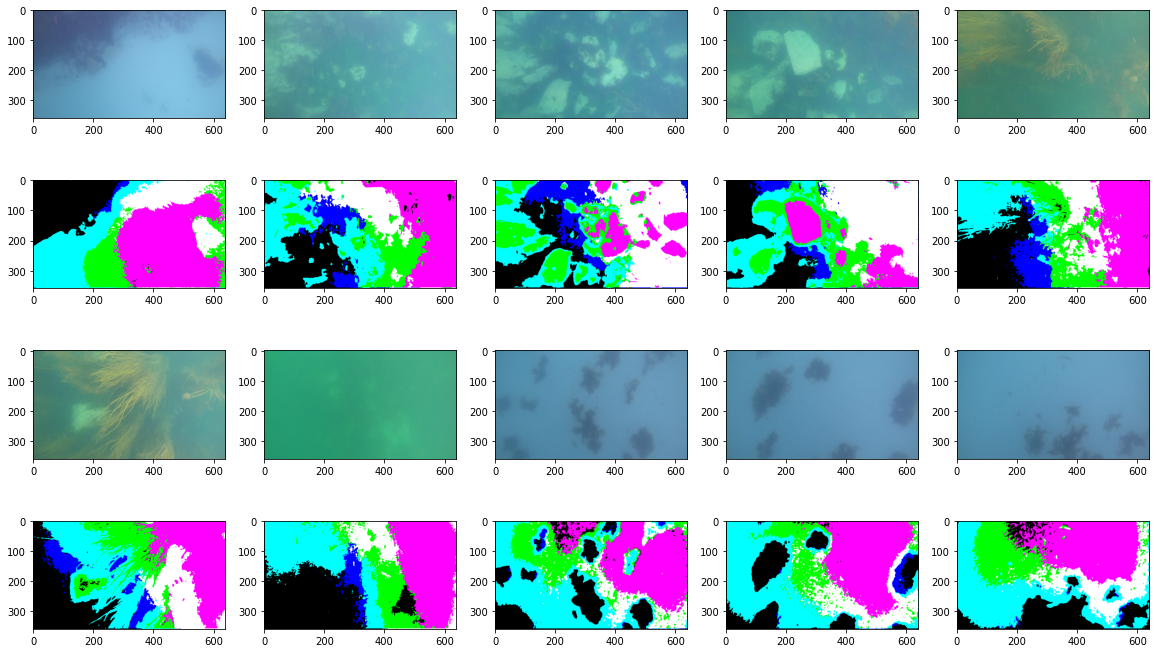

In [255]:
# resuts for maxIter = 2
# with 2 iterations
model = MyNet(im.shape[2])
if use_cuda:
    model.cuda()
model.train()

# similarity loss definition
loss_fn = torch.nn.CrossEntropyLoss()

# continuity loss definition
loss_hpy = torch.nn.L1Loss(reduction='mean')
loss_hpz = torch.nn.L1Loss(reduction='mean')

optimizer = optim.SGD(model.parameters(), lr=params['lr'], momentum=0.9)
label_colours = np.random.randint(255, size=(100, 3))
size = (128,128)

params = {"scribble":False,
          "batch_size":6,
          "nChannel": 10,
          "maxIter": 2, 
          "minLabels": 3, 
          "lr": 0.01,
          "nConv":2,
          "visualize":1,
          "input": (path_data/'datasets/').as_posix(),
          "stepsize_sim":1,
          "stepsize_con":1,
          "stepsize_scr":0.5}


# train 
train()
# inference on test folder
list_result, list_inds = test()


fig, axs = plt.subplots(nrows=4, ncols = 5, figsize=(20,12))
ncols = 5
for col in range(ncols):
    image = mpimg.imread(img_list_test[col])
    axs[0, col].imshow(image)
#for col in range(ncols):
#    axs[1, col].imshow(list_result[col])   
for col in range(ncols):
    axs[1,col].imshow(decode_segmap(list_inds[col]))    
for col in range(ncols):
    image = mpimg.imread(img_list_test[ncols+col])
    axs[2, col].imshow(image)
#for col in range(ncols):
#    axs[4, col].imshow(list_result[ncols+col])
for col in range(ncols):
    axs[3,col].imshow(decode_segmap(list_inds[ncols+col]))

### 3. with maxIter=1, stepsize_con=1, lr =0.1

 50%|█████     | 3/6 [00:00<00:00, 24.50it/s]

Training started. 2020-12-14 14:04:56.103103   1 / 1
0 / 6 |  label num : 10  | loss : 1.9673787355422974
1 / 6 |  label num : 9  | loss : 1.6829906702041626
2 / 6 |  label num : 10  | loss : 1.831587314605713
3 / 6 |  label num : 10  | loss : 1.7080538272857666
4 / 6 |  label num : 9  | loss : 1.6737815141677856


 50%|█████     | 3/6 [00:00<00:00, 26.82it/s]

5 / 6 |  label num : 8  | loss : 1.5946078300476074
0 / 6 |  label num : 7  | loss : 1.442456841468811
1 / 6 |  label num : 6  | loss : 1.327260971069336
2 / 6 |  label num : 6  | loss : 1.2398089170455933
3 / 6 |  label num : 6  | loss : 1.2710070610046387
4 / 6 |  label num : 5  | loss : 0.9219271540641785


 50%|█████     | 3/6 [00:00<00:00, 24.45it/s]

5 / 6 |  label num : 6  | loss : 1.1490309238433838
0 / 6 |  label num : 7  | loss : 0.7199530005455017
1 / 6 |  label num : 8  | loss : 1.2467951774597168
2 / 6 |  label num : 8  | loss : 1.1827247142791748
3 / 6 |  label num : 5  | loss : 1.091361165046692


 40%|████      | 4/10 [00:00<00:00, 38.54it/s]

4 / 6 |  label num : 6  | loss : 0.9799402356147766
5 / 6 |  label num : 5  | loss : 1.025115728378296
Testing 10 images.


100%|██████████| 10/10 [00:00<00:00, 36.33it/s]


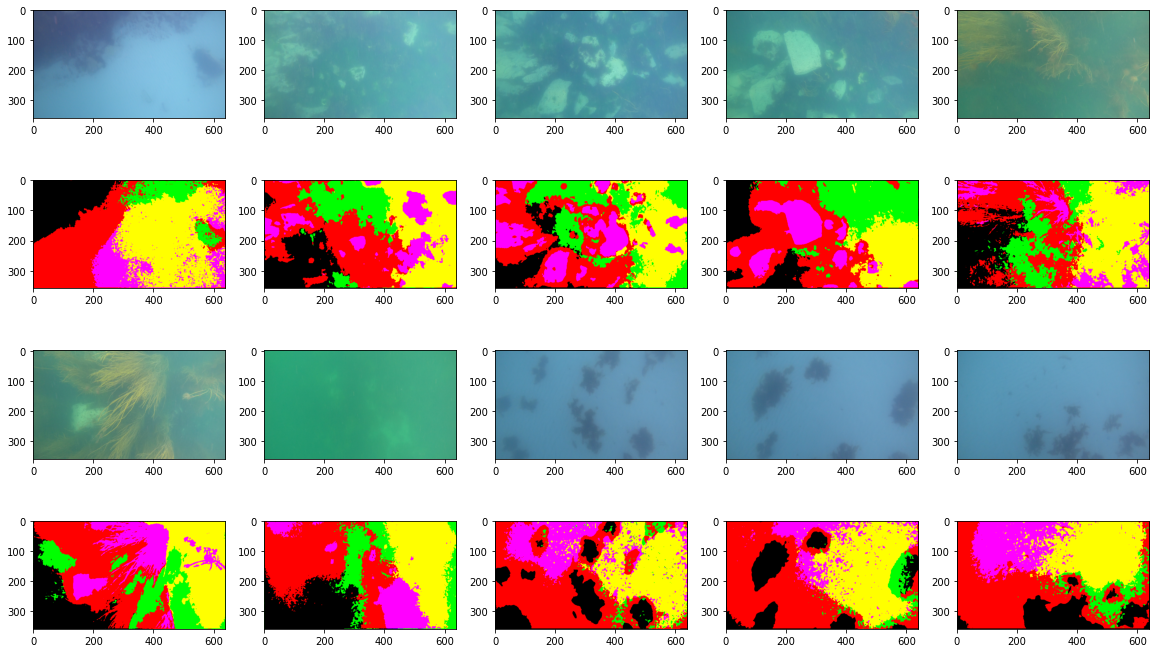

In [262]:
# resuts for maxIter = 4
# with 2 iterations
model = MyNet(im.shape[2])
if use_cuda:
    model.cuda()
model.train()

# similarity loss definition
loss_fn = torch.nn.CrossEntropyLoss()

# continuity loss definition
loss_hpy = torch.nn.L1Loss(reduction='mean')
loss_hpz = torch.nn.L1Loss(reduction='mean')

optimizer = optim.SGD(model.parameters(), lr=params['lr'], momentum=0.9)
label_colours = np.random.randint(255, size=(100, 3))
size = (128,128)

params = {"scribble":False,
          "batch_size":6,
          "nChannel": 10,
          "maxIter": 1, 
          "minLabels": 3, 
          "lr": 0.1,
          "nConv":2,
          "visualize":1,
          "input": (path_data/'datasets/').as_posix(),
          "stepsize_sim":1,
          "stepsize_con":1,
          "stepsize_scr":0.5}


# train 
train()
# inference on test folder
list_result, list_inds = test()


fig, axs = plt.subplots(nrows=4, ncols = 5, figsize=(20,12))
ncols = 5
for col in range(ncols):
    image = mpimg.imread(img_list_test[col])
    axs[0, col].imshow(image)
#for col in range(ncols):
#    axs[1, col].imshow(list_result[col])   
for col in range(ncols):
    axs[1,col].imshow(decode_segmap(list_inds[col]))    
for col in range(ncols):
    image = mpimg.imread(img_list_test[ncols+col])
    axs[2, col].imshow(image)
#for col in range(ncols):
#    axs[4, col].imshow(list_result[ncols+col])
for col in range(ncols):
    axs[3,col].imshow(decode_segmap(list_inds[ncols+col]))

### 4. with maxIter=4, stepsize_con=1, lr =0.1

 50%|█████     | 3/6 [00:00<00:00, 25.62it/s]

Training started. 2020-12-14 14:06:11.267240   1 / 4
0 / 6 |  label num : 10  | loss : 1.9955331087112427
1 / 6 |  label num : 10  | loss : 1.8895710706710815
2 / 6 |  label num : 10  | loss : 1.554218053817749
3 / 6 |  label num : 10  | loss : 1.434661865234375
4 / 6 |  label num : 10  | loss : 1.3101452589035034


 50%|█████     | 3/6 [00:00<00:00, 26.35it/s]

5 / 6 |  label num : 9  | loss : 1.23833429813385
0 / 6 |  label num : 7  | loss : 1.2049026489257812
1 / 6 |  label num : 7  | loss : 1.1212284564971924
2 / 6 |  label num : 6  | loss : 0.9742505550384521
3 / 6 |  label num : 8  | loss : 1.175910472869873
4 / 6 |  label num : 7  | loss : 0.7472996711730957


 50%|█████     | 3/6 [00:00<00:00, 25.09it/s]

5 / 6 |  label num : 6  | loss : 1.056297779083252
0 / 6 |  label num : 7  | loss : 0.5045661926269531
1 / 6 |  label num : 7  | loss : 1.046808123588562
2 / 6 |  label num : 7  | loss : 0.9112119674682617
3 / 6 |  label num : 6  | loss : 0.8362995982170105
4 / 

 50%|█████     | 3/6 [00:00<00:00, 24.92it/s]

6 |  label num : 7  | loss : 0.7234854102134705
5 / 6 |  label num : 5  | loss : 0.6998199224472046
Training started. 2020-12-14 14:06:11.977871   2 / 4
0 / 6 |  label num : 6  | loss : 0.5483458042144775
1 / 6 |  label num : 6  | loss : 0.4536568522453308
2 / 6 |  label num : 6  | loss : 0.4224362075328827


  0%|          | 0/6 [00:00<?, ?it/s]

3 / 6 |  label num : 6  | loss : 0.4389672875404358
4 / 6 |  label num : 5  | loss : 0.40064215660095215
5 / 6 |  label num : 4  | loss : 0.267697811126709
0 / 6 |  label num : 4  | loss : 0.2422693818807602
1 / 6 |  label num : 4  | loss : 0.24709463119506836


  0%|          | 0/6 [00:00<?, ?it/s]

2 / 6 |  label num : 4  | loss : 0.265451580286026
3 / 6 |  label num : 4  | loss : 0.591166079044342
4 / 6 |  label num : 4  | loss : 0.4594344198703766
5 / 6 |  label num : 5  | loss : 0.5952215790748596
0 / 6 |  label num : 5  | loss : 0.2844620943069458


  0%|          | 0/6 [00:00<?, ?it/s]

1 / 6 |  label num : 5  | loss : 0.5076296925544739
2 / 6 |  label num : 5  | loss : 0.46681082248687744
3 / 6 |  label num : 4  | loss : 0.33956989645957947
4 / 6 |  label num : 5  | loss : 0.320944607257843
5 / 6 |  label num : 4  | loss : 0.23158305883407593
Training started. 2020-12-14 14:06:12.749674   3 / 4


 50%|█████     | 3/6 [00:00<00:00, 23.44it/s]

0 / 6 |  label num : 5  | loss : 0.3792417049407959
1 / 6 |  label num : 5  | loss : 0.25220704078674316
2 / 6 |  label num : 5  | loss : 0.2561664283275604
3 / 6 |  label num : 5  | loss : 0.3036085367202759
4 / 6 |  label num : 5  | loss : 0.29595842957496643


 50%|█████     | 3/6 [00:00<00:00, 25.04it/s]

5 / 6 |  label num : 4  | loss : 0.19886426627635956
0 / 6 |  label num : 4  | loss : 0.20725330710411072
1 / 6 |  label num : 4  | loss : 0.1933356523513794
2 / 6 |  label num : 4  | loss : 0.19853809475898743
3 / 6 |  label num : 4  | loss : 0.24651966989040375
4 / 6 |  label num : 5  | loss : 0.2636805772781372


 50%|█████     | 3/6 [00:00<00:00, 24.51it/s]

5 / 6 |  label num : 5  | loss : 0.320381224155426
0 / 6 |  label num : 5  | loss : 0.3835507035255432
1 / 6 |  label num : 4  | loss : 0.2860504984855652
2 / 6 |  label num : 4  | loss : 0.3519885540008545
3 / 6 |  label num : 4  | loss : 0.2992505729198456


 50%|█████     | 3/6 [00:00<00:00, 25.87it/s]

4 / 6 |  label num : 4  | loss : 0.265841007232666
5 / 6 |  label num : 4  | loss : 0.2107400894165039
Training started. 2020-12-14 14:06:13.488754   4 / 4
0 / 6 |  label num : 4  | loss : 0.28714850544929504
1 / 6 |  label num : 4  | loss : 0.2617853879928589
2 / 6 |  label num : 4  | loss : 0.24992460012435913
3 / 6 |  label num : 4  | loss : 0.24693278968334198


 50%|█████     | 3/6 [00:00<00:00, 19.09it/s]

4 / 6 |  label num : 5  | loss : 0.2282390296459198
5 / 6 |  label num : 4  | loss : 0.22344514727592468
0 / 6 |  label num : 4  | loss : 0.16564714908599854
1 / 6 |  label num : 4  | loss : 0.15691456198692322
2 / 6 |  label num : 4  | loss : 0.14430926740169525
3 / 6 |  label num : 3  | loss : 0.1327783167362213
nLabels 3 reached minLabels 3 .



 50%|█████     | 3/6 [00:00<00:00, 23.79it/s]

0 / 6 |  label num : 5  | loss : 0.3355250954627991
1 / 6 |  label num : 4  | loss : 0.23629742860794067
2 / 6 |  label num : 4  | loss : 0.2904151380062103
3 / 6 |  label num : 4  | loss : 0.1850234866142273
4 / 6 |  label num : 4  | loss : 0.19583827257156372


 40%|████      | 4/10 [00:00<00:00, 35.09it/s]

5 / 6 |  label num : 3  | loss : 0.1404079794883728
nLabels 3 reached minLabels 3 .
Testing 10 images.


100%|██████████| 10/10 [00:00<00:00, 36.16it/s]


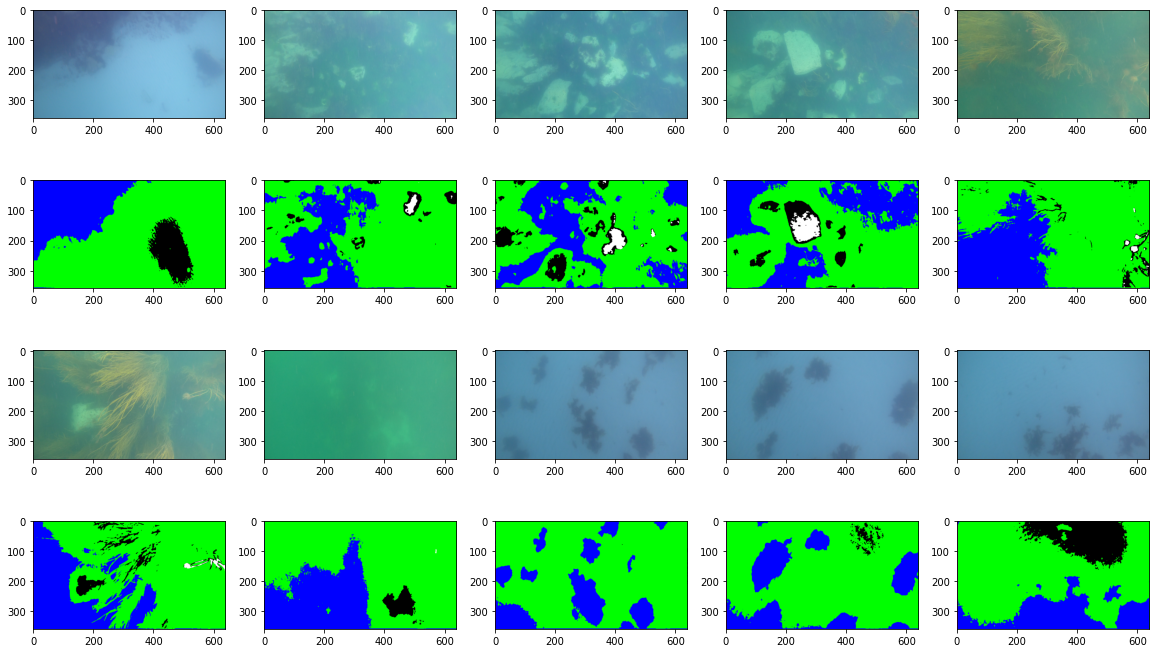

In [264]:
# resuts for maxIter = 4, lr = 0.1
# with 2 iterations
model = MyNet(im.shape[2])
if use_cuda:
    model.cuda()
model.train()

# similarity loss definition
loss_fn = torch.nn.CrossEntropyLoss()

# continuity loss definition
loss_hpy = torch.nn.L1Loss(reduction='mean')
loss_hpz = torch.nn.L1Loss(reduction='mean')

optimizer = optim.SGD(model.parameters(), lr=params['lr'], momentum=0.9)
label_colours = np.random.randint(255, size=(100, 3))
size = (128,128)

params = {"scribble":False,
          "batch_size":6,
          "nChannel": 10,
          "maxIter": 4, 
          "minLabels": 3, 
          "lr": 0.1,
          "nConv":2,
          "visualize":1,
          "input": (path_data/'datasets/').as_posix(),
          "stepsize_sim":1,
          "stepsize_con":1,
          "stepsize_scr":0.5}


# train 
train()
# inference on test folder
list_result, list_inds = test()


fig, axs = plt.subplots(nrows=4, ncols = 5, figsize=(20,12))
ncols = 5
for col in range(ncols):
    image = mpimg.imread(img_list_test[col])
    axs[0, col].imshow(image)
#for col in range(ncols):
#    axs[1, col].imshow(list_result[col])   
for col in range(ncols):
    axs[1,col].imshow(decode_segmap(list_inds[col]))    
for col in range(ncols):
    image = mpimg.imread(img_list_test[ncols+col])
    axs[2, col].imshow(image)
#for col in range(ncols):
#    axs[4, col].imshow(list_result[ncols+col])
for col in range(ncols):
    axs[3,col].imshow(decode_segmap(list_inds[ncols+col]))

### 5. with maxIter=4, stepsize_con=5, lr =0.1

 50%|█████     | 3/6 [00:00<00:00, 24.71it/s]

Training started. 2020-12-14 14:08:44.989711   1 / 4
0 / 6 |  label num : 10  | loss : 3.4056026935577393
1 / 6 |  label num : 9  | loss : 2.1184091567993164
2 / 6 |  label num : 9  | loss : 2.023327350616455
3 / 6 |  label num : 8  | loss : 1.743622064590454


 50%|█████     | 3/6 [00:00<00:00, 26.20it/s]

4 / 6 |  label num : 7  | loss : 1.6687877178192139
5 / 6 |  label num : 6  | loss : 1.578750729560852
0 / 6 |  label num : 5  | loss : 1.6298046112060547
1 / 6 |  label num : 4  | loss : 1.5510809421539307
2 / 6 |  label num : 4  | loss : 1.5595494508743286
3 / 6 |  label num : 4  | loss : 1.2919921875


  0%|          | 0/6 [00:00<?, ?it/s]

4 / 6 |  label num : 4  | loss : 1.0300015211105347
5 / 6 |  label num : 3  | loss : 1.1669738292694092
nLabels 3 reached minLabels 3 .
0 / 6 |  label num : 3  | loss : 1.1919727325439453
nLabels 3 reached minLabels 3 .
Training started. 2020-12-14 14:08:45.506076   2 / 4
0 / 6 |  label num : 3  | loss : 0.8692309260368347
nLabels 3 reached minLabels 3 .
0 / 6 |  label num : 2  | loss : 0.5874159336090088
nLabels 2 reached minLabels 3 .


  0%|          | 0/6 [00:00<?, ?it/s]

0 / 6 |  label num : 3  | loss : 0.8708542585372925
nLabels 3 reached minLabels 3 .
Training started. 2020-12-14 14:08:45.636984   3 / 4
0 / 6 |  label num : 3  | loss : 0.629224419593811
nLabels 3 reached minLabels 3 .
0 / 6 |  label num : 2  | loss : 0.5073650479316711
nLabels 2 reached minLabels 3 .
0 / 6 |  label num : 3  | loss : 0.7402207851409912
nLabels 3 reached minLabels 3 .
Training started. 2020-12-14 14:08:45.772724   4 / 4
0 / 6 |  label num : 3  | loss : 0.5571621060371399
nLabels 3 reached minLabels 3 .


 40%|████      | 4/10 [00:00<00:00, 35.30it/s]

0 / 6 |  label num : 2  | loss : 0.42183202505111694
nLabels 2 reached minLabels 3 .
0 / 6 |  label num : 3  | loss : 0.6589186787605286
nLabels 3 reached minLabels 3 .
Testing 10 images.


100%|██████████| 10/10 [00:00<00:00, 34.79it/s]


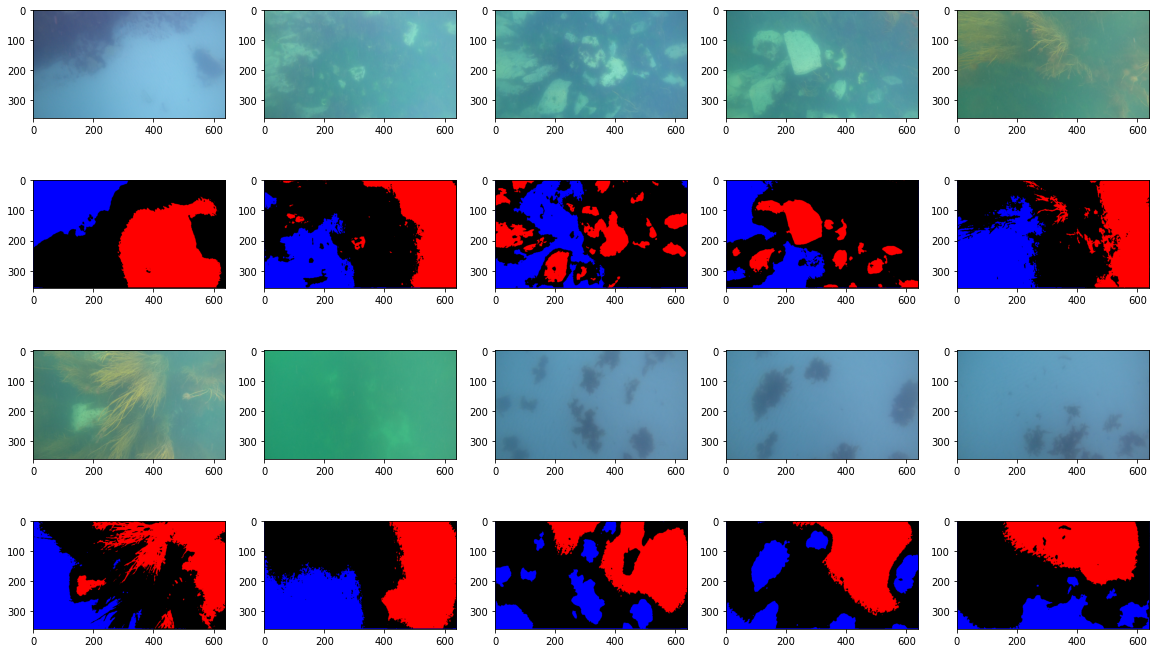

In [265]:
# resuts for maxIter = 4
# with 2 iterations
model = MyNet(im.shape[2])
if use_cuda:
    model.cuda()
model.train()

# similarity loss definition
loss_fn = torch.nn.CrossEntropyLoss()

# continuity loss definition
loss_hpy = torch.nn.L1Loss(reduction='mean')
loss_hpz = torch.nn.L1Loss(reduction='mean')

optimizer = optim.SGD(model.parameters(), lr=params['lr'], momentum=0.9)
label_colours = np.random.randint(255, size=(100, 3))
size = (128,128)

params = {"scribble":False,
          "batch_size":6,
          "nChannel": 10,
          "maxIter": 4, 
          "minLabels": 3, 
          "lr": 0.1,
          "nConv":2,
          "visualize":1,
          "input": (path_data/'datasets/').as_posix(),
          "stepsize_sim":1,
          "stepsize_con":5,
          "stepsize_scr":0.5}


# train 
train()
# inference on test folder
list_result, list_inds = test()


fig, axs = plt.subplots(nrows=4, ncols = 5, figsize=(20,12))
ncols = 5
for col in range(ncols):
    image = mpimg.imread(img_list_test[col])
    axs[0, col].imshow(image)
#for col in range(ncols):
#    axs[1, col].imshow(list_result[col])   
for col in range(ncols):
    axs[1,col].imshow(decode_segmap(list_inds[col]))    
for col in range(ncols):
    image = mpimg.imread(img_list_test[ncols+col])
    axs[2, col].imshow(image)
#for col in range(ncols):
#    axs[4, col].imshow(list_result[ncols+col])
for col in range(ncols):
    axs[3,col].imshow(decode_segmap(list_inds[ncols+col]))

### 6. with maxIter=4, stepsize_con=5, lr =0.1, minLabels=2

 50%|█████     | 3/6 [00:00<00:00, 26.35it/s]

Training started. 2020-12-14 14:15:02.442351   1 / 10
0 / 6 |  label num : 10  | loss : 3.8551862239837646
1 / 6 |  label num : 10  | loss : 2.3721280097961426
2 / 6 |  label num : 9  | loss : 1.9687485694885254
3 / 6 |  label num : 7  | loss : 1.821465015411377
4 / 6 |  label num : 7  | loss : 1.7887763977050781


 50%|█████     | 3/6 [00:00<00:00, 27.84it/s]

5 / 6 |  label num : 5  | loss : 1.5393972396850586
0 / 6 |  label num : 4  | loss : 1.6209851503372192
1 / 6 |  label num : 4  | loss : 1.4625728130340576
2 / 6 |  label num : 4  | loss : 1.3545620441436768
3 / 6 |  label num : 4  | loss : 1.230633020401001
4 / 6 |  label num : 4  | loss : 0.9164049625396729


 50%|█████     | 3/6 [00:00<00:00, 24.75it/s]

5 / 6 |  label num : 4  | loss : 1.0739549398422241
0 / 6 |  label num : 4  | loss : 1.122965693473816
1 / 6 |  label num : 4  | loss : 1.1715304851531982
2 / 6 |  label num : 4  | loss : 1.1835168600082397
3 / 6 |  label num : 4  | loss : 0.9630836844444275
4 / 6 |  label num : 

 50%|█████     | 3/6 [00:00<00:00, 25.07it/s]

4  | loss : 0.7622324824333191
5 / 6 |  label num : 4  | loss : 0.8444893956184387
Training started. 2020-12-14 14:15:03.131840   2 / 10
0 / 6 |  label num : 3  | loss : 0.5523526668548584
1 / 6 |  label num : 3  | loss : 0.5182632803916931
2 / 6 |  label num : 3  | loss : 0.47452062368392944


  0%|          | 0/6 [00:00<?, ?it/s]

3 / 6 |  label num : 3  | loss : 0.41638389229774475
4 / 6 |  label num : 3  | loss : 0.4908490777015686
5 / 6 |  label num : 3  | loss : 0.4364054799079895
0 / 6 |  label num : 3  | loss : 0.4343259930610657
1 / 6 |  label num : 3  | loss : 0.5169631242752075


  0%|          | 0/6 [00:00<?, ?it/s]

2 / 6 |  label num : 3  | loss : 0.4602520763874054
3 / 6 |  label num : 3  | loss : 0.5015647411346436
4 / 6 |  label num : 3  | loss : 0.4945240914821625
5 / 6 |  label num : 3  | loss : 0.5864388942718506
0 / 6 |  label num : 3  | loss : 0.7291895747184753


  0%|          | 0/6 [00:00<?, ?it/s]

1 / 6 |  label num : 3  | loss : 0.721523642539978
2 / 6 |  label num : 3  | loss : 0.9170611500740051
3 / 6 |  label num : 3  | loss : 0.6214557886123657
4 / 6 |  label num : 3  | loss : 0.5316454768180847
5 / 6 |  label num : 3  | loss : 0.5162335634231567
Training started. 2020-12-14 14:15:03.872758   3 / 10


100%|██████████| 6/6 [00:00<00:00, 24.54it/s]

0 / 6 |  label num : 3  | loss : 0.4209471344947815
1 / 6 |  label num : 3  | loss : 0.40012818574905396
2 / 6 |  label num : 3  | loss : 0.364139199256897
3 / 6 |  label num : 3  | loss : 0.3247014284133911
4 / 6 |  label num : 3  | loss : 0.39688217639923096
5 / 6 |  label num : 3  | loss : 0.35034289956092834


  0%|          | 0/6 [00:00<?, ?it/s]

0 / 6 |  label num : 3  | loss : 0.3453294038772583
1 / 6 |  label num : 3  | loss : 0.41438424587249756
2 / 6 |  label num : 3  | loss : 0.3752165138721466
3 / 6 |  label num : 3  | loss : 0.406855970621109
4 / 6 |  label num : 3  | loss : 0.4008479118347168
5 / 6 |  label num : 3  | loss : 0.4124463200569153


  0%|          | 0/6 [00:00<?, ?it/s]

0 / 6 |  label num : 3  | loss : 0.5552886128425598
1 / 6 |  label num : 3  | loss : 0.6165144443511963
2 / 6 |  label num : 3  | loss : 0.7168658375740051
3 / 6 |  label num : 3  | loss : 0.46960657835006714
4 / 6 |  label num : 3  | loss : 0.42392271757125854
5 / 6 |  label num : 3  | loss : 0.4412798285484314
Training started. 2020-12-14 14:15:04.579916   4 / 10


  0%|          | 0/6 [00:00<?, ?it/s]

0 / 6 |  label num : 3  | loss : 0.3626001477241516
1 / 6 |  label num : 3  | loss : 0.3243422210216522
2 / 6 |  label num : 3  | loss : 0.3188238739967346
3 / 6 |  label num : 3  | loss : 0.2813754975795746
4 / 6 |  label num : 3  | loss : 0.31667929887771606
5 / 6 |  label num : 3  | loss : 0.28628936409950256


  0%|          | 0/6 [00:00<?, ?it/s]

0 / 6 |  label num : 3  | loss : 0.27125683426856995
1 / 6 |  label num : 3  | loss : 0.3363010287284851
2 / 6 |  label num : 3  | loss : 0.32548007369041443
3 / 6 |  label num : 3  | loss : 0.34250393509864807
4 / 6 |  label num : 3  | loss : 0.35614803433418274
5 / 6 |  label num : 3  | loss : 0.3168116509914398


  0%|          | 0/6 [00:00<?, ?it/s]

0 / 6 |  label num : 3  | loss : 0.4910546541213989
1 / 6 |  label num : 3  | loss : 0.46936550736427307
2 / 6 |  label num : 3  | loss : 0.6451016664505005
3 / 6 |  label num : 3  | loss : 0.37212488055229187
4 / 6 |  label num : 3  | loss : 0.3312684893608093
5 / 6 |  label num : 3  | loss : 0.3964238166809082
Training started. 2020-12-14 14:15:05.268176   5 / 10


  0%|          | 0/6 [00:00<?, ?it/s]

0 / 6 |  label num : 3  | loss : 0.3584950566291809
1 / 6 |  label num : 3  | loss : 0.2746577262878418
2 / 6 |  label num : 3  | loss : 0.24434439837932587
3 / 6 |  label num : 3  | loss : 0.23985472321510315
4 / 6 |  label num : 3  | loss : 0.2650025486946106
5 / 6 |  label num : 3  | loss : 0.28594040870666504


  0%|          | 0/6 [00:00<?, ?it/s]

0 / 6 |  label num : 3  | loss : 0.25436022877693176
1 / 6 |  label num : 3  | loss : 0.31930699944496155
2 / 6 |  label num : 2  | loss : 0.3078513443470001
nLabels 2 reached minLabels 2 .
0 / 6 |  label num : 3  | loss : 0.44313183426856995
1 / 6 |  label num : 2  | loss : 0.3284951448440552
nLabels 2 reached minLabels 2 .
Training started. 2020-12-14 14:15:05.682179   6 / 10
0 / 6 |  label num : 3  | loss : 0.291365385055542


  0%|          | 0/6 [00:00<?, ?it/s]

1 / 6 |  label num : 3  | loss : 0.2892841696739197
2 / 6 |  label num : 3  | loss : 0.27661585807800293
3 / 6 |  label num : 3  | loss : 0.279035747051239
4 / 6 |  label num : 3  | loss : 0.25657519698143005
5 / 6 |  label num : 3  | loss : 0.2767455279827118
0 / 6 |  label num : 3  | loss : 0.20098590850830078


  0%|          | 0/6 [00:00<?, ?it/s]

1 / 6 |  label num : 3  | loss : 0.24824050068855286
2 / 6 |  label num : 2  | loss : 0.26534903049468994
nLabels 2 reached minLabels 2 .
0 / 6 |  label num : 3  | loss : 0.3933875560760498
1 / 6 |  label num : 2  | loss : 0.29779359698295593
nLabels 2 reached minLabels 2 .
Training started. 2020-12-14 14:15:06.096618   7 / 10
0 / 6 |  label num : 3  | loss : 0.2531607747077942
1 / 6 |  label num : 3  | loss : 0.2376362383365631


  0%|          | 0/6 [00:00<?, ?it/s]

2 / 6 |  label num : 3  | loss : 0.22458486258983612
3 / 6 |  label num : 3  | loss : 0.23829913139343262
4 / 6 |  label num : 3  | loss : 0.238499253988266
5 / 6 |  label num : 3  | loss : 0.2869010865688324
0 / 6 |  label num : 3  | loss : 0.18128855526447296
1 / 6 |  label num : 3  | loss : 0.19506947696208954


 50%|█████     | 3/6 [00:00<00:00, 28.05it/s]

2 / 6 |  label num : 2  | loss : 0.17665596306324005
nLabels 2 reached minLabels 2 .
0 / 6 |  label num : 3  | loss : 0.30226579308509827
1 / 6 |  label num : 2  | loss : 0.17011544108390808
nLabels 2 reached minLabels 2 .
Training started. 2020-12-14 14:15:06.506327   8 / 10
0 / 6 |  label num : 3  | loss : 0.21895763278007507
1 / 6 |  label num : 3  | loss : 0.2555080056190491
2 / 6 |  label num : 3  | loss : 0.27984198927879333


  0%|          | 0/6 [00:00<?, ?it/s]

3 / 6 |  label num : 3  | loss : 0.32335981726646423
4 / 6 |  label num : 3  | loss : 0.27934741973876953
5 / 6 |  label num : 3  | loss : 0.26084214448928833
0 / 6 |  label num : 3  | loss : 0.18292538821697235
1 / 6 |  label num : 3  | loss : 0.20397397875785828
2 / 6 |  label num : 2  | loss : 0.18228144943714142
nLabels 2 reached minLabels 2 .


 50%|█████     | 3/6 [00:00<00:00, 27.56it/s]

0 / 6 |  label num : 3  | loss : 0.3292410969734192
1 / 6 |  label num : 2  | loss : 0.2077750265598297
nLabels 2 reached minLabels 2 .
Training started. 2020-12-14 14:15:06.912730   9 / 10
0 / 6 |  label num : 3  | loss : 0.19469226896762848
1 / 6 |  label num : 3  | loss : 0.21164587140083313
2 / 6 |  label num : 3  | loss : 0.21298429369926453
3 / 6 |  label num : 3  | loss : 0.23577433824539185


  0%|          | 0/6 [00:00<?, ?it/s]

4 / 6 |  label num : 3  | loss : 0.22894206643104553
5 / 6 |  label num : 3  | loss : 0.26064634323120117
0 / 6 |  label num : 3  | loss : 0.16717246174812317
1 / 6 |  label num : 3  | loss : 0.17878663539886475
2 / 6 |  label num : 2  | loss : 0.15079566836357117
nLabels 2 reached minLabels 2 .
0 / 6 |  label num : 3  | loss : 0.26132047176361084


 50%|█████     | 3/6 [00:00<00:00, 27.94it/s]

1 / 6 |  label num : 2  | loss : 0.13301631808280945
nLabels 2 reached minLabels 2 .
Training started. 2020-12-14 14:15:07.321843   10 / 10
0 / 6 |  label num : 3  | loss : 0.1570063680410385
1 / 6 |  label num : 3  | loss : 0.19122935831546783
2 / 6 |  label num : 3  | loss : 0.2057543694972992
3 / 6 |  label num : 3  | loss : 0.22619324922561646
4 / 6 |  label num : 3  | loss : 0.22080688178539276


  0%|          | 0/10 [00:00<?, ?it/s]

5 / 6 |  label num : 3  | loss : 0.2326917052268982
0 / 6 |  label num : 3  | loss : 0.1720709502696991
1 / 6 |  label num : 3  | loss : 0.17224809527397156
2 / 6 |  label num : 2  | loss : 0.12122105807065964
nLabels 2 reached minLabels 2 .
0 / 6 |  label num : 2  | loss : 0.16782468557357788
nLabels 2 reached minLabels 2 .
Testing 10 images.


100%|██████████| 10/10 [00:00<00:00, 41.30it/s]


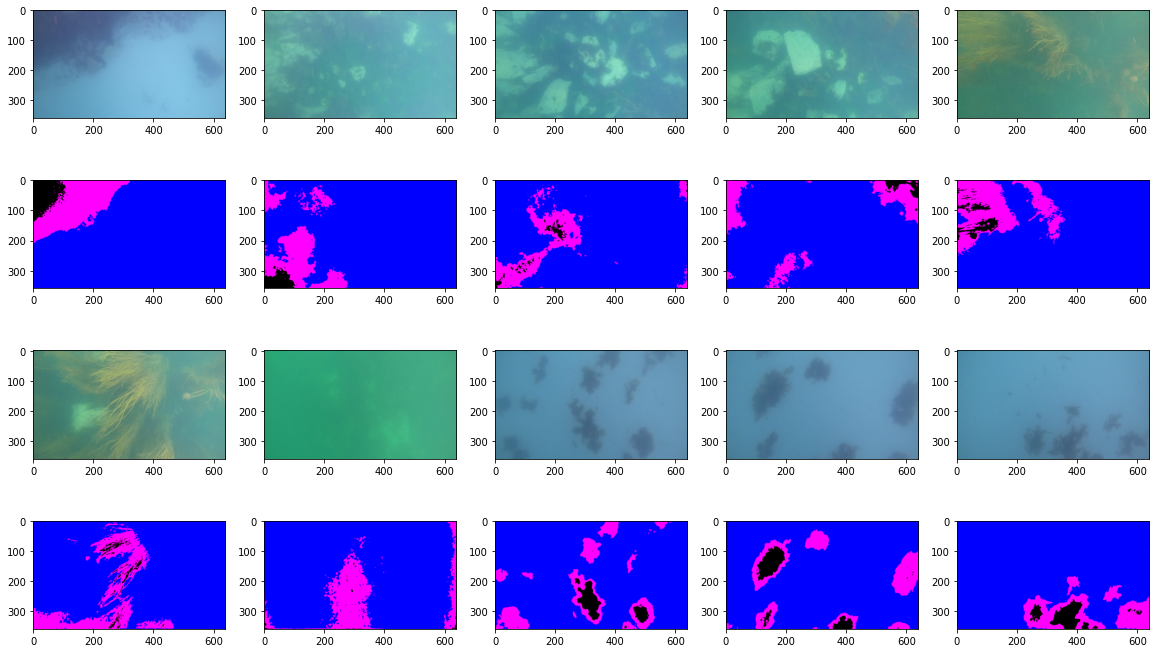

In [269]:
# resuts for maxIter = 4
# with 2 iterations
model = MyNet(im.shape[2])
if use_cuda:
    model.cuda()
model.train()

# similarity loss definition
loss_fn = torch.nn.CrossEntropyLoss()

# continuity loss definition
loss_hpy = torch.nn.L1Loss(reduction='mean')
loss_hpz = torch.nn.L1Loss(reduction='mean')

optimizer = optim.SGD(model.parameters(), lr=params['lr'], momentum=0.9)
label_colours = np.random.randint(255, size=(100, 3))
size = (128,128)

params = {"scribble":False,
          "batch_size":6,
          "nChannel": 10,
          "maxIter": 10, 
          "minLabels": 2, 
          "lr": 0.1,
          "nConv":2,
          "visualize":1,
          "input": (path_data/'datasets/').as_posix(),
          "stepsize_sim":1,
          "stepsize_con":5,
          "stepsize_scr":0.5}


# train 
train()
# inference on test folder
list_result, list_inds = test()


fig, axs = plt.subplots(nrows=4, ncols = 5, figsize=(20,12))
ncols = 5
for col in range(ncols):
    image = mpimg.imread(img_list_test[col])
    axs[0, col].imshow(image)
#for col in range(ncols):
#    axs[1, col].imshow(list_result[col])   
for col in range(ncols):
    axs[1,col].imshow(decode_segmap(list_inds[col]))    
for col in range(ncols):
    image = mpimg.imread(img_list_test[ncols+col])
    axs[2, col].imshow(image)
#for col in range(ncols):
#    axs[4, col].imshow(list_result[ncols+col])
for col in range(ncols):
    axs[3,col].imshow(decode_segmap(list_inds[ncols+col]))